Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
history=pd.read_csv('historical_data.csv')
sentiment=pd.read_csv('fear_greed_index.csv')

In [3]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [4]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


The sentiment data has 4 rows and 2644 columns with no null values. The historical data has 2644 rows and 7 columns with no null values. The timestamp column in the historical data is in Unix format.

In [5]:
history['Timestamp']=pd.to_datetime(history['Timestamp'],unit='ms')
history['Timestamp']=history['Timestamp'].dt.date

In [6]:
history.drop(columns=['Timestamp IST'],inplace=True)

In [7]:
history.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-10-27
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-10-27
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-10-27
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-10-27
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-10-27


In [8]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [9]:
sentiment['timestamp']=pd.to_datetime(sentiment['timestamp'],unit='s')
sentiment['timestamp']=sentiment['timestamp'].dt.date

In [10]:
sentiment.head()

,timestamp,value,classification,date
0,2018-02-01,30,Fear,2018-02-01
1,2018-02-02,15,Extreme Fear,2018-02-02
2,2018-02-03,40,Fear,2018-02-03
3,2018-02-04,24,Extreme Fear,2018-02-04
4,2018-02-05,11,Extreme Fear,2018-02-05


In [22]:
history['is_win'] = history['Closed PnL'] > 0
history['is_long_entry'] = history['Direction'].str.lower().str.contains('open long')
history['is_short_entry'] = history['Direction'].str.lower().str.contains('open short')
history['net_pnl'] = history['Closed PnL'] - history['Fee']

In [21]:
history['Direction'].unique()

array(['Buy', 'Sell', 'Open Long', 'Close Long', 'Spot Dust Conversion',
       'Open Short', 'Close Short', 'Long > Short', 'Short > Long',
       'Auto-Deleveraging', 'Liquidated Isolated Short', 'Settlement'],
      dtype=object)

In [13]:
daily_metrics = (
    history
    .groupby(['Account', 'Timestamp'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        net_daily_pnl=('net_pnl', 'sum'),
        trades_per_day=('Closed PnL', 'count'),
        avg_trade_size=('Size USD', 'mean'),
        win_rate=('is_win', 'mean'),
        long_ratio=('is_long', 'mean'),
        total_fees=('Fee', 'sum')
    )
    .reset_index()
)

In [14]:
daily_metrics.rename(columns={'Timestamp': 'timestamp'}, inplace=True)

In [15]:
print(daily_metrics.columns)
print(sentiment.columns)

Index(['Account', 'timestamp', 'daily_pnl', 'net_daily_pnl', 'trades_per_day',
       'avg_trade_size', 'win_rate', 'long_ratio', 'total_fees'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [16]:
analysis_df = daily_metrics.merge(
    sentiment[['timestamp','classification']],
    on='timestamp',
    how='inner'
)
analysis_df.head()

,Account,timestamp,daily_pnl,net_daily_pnl,trades_per_day,avg_trade_size,win_rate,long_ratio,total_fees,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,-3.286188e+05,462,14810.891818,0.025974,0.0,1112.895650,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,1.921443e+06,3356,16345.241940,0.405542,0.0,6292.416654,Fear
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,2.040528e+04,320,2492.749906,0.531250,0.0,202.167151,Greed
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,1.543381e+04,3533,1693.351684,0.435041,0.0,1664.914670,Fear
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.000000e+00,-1.119793e+01,5,6070.200000,0.000000,0.0,10.197932,Neutral


In [17]:
analysis_df.groupby('classification')['daily_pnl'].describe()

,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Greed,5.0,35393.098355,85325.499902,-7919.471032,-5564.016140,0.000000,2606.894756,1.878421e+05
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,32.0,99675.516731,282694.285526,-327505.900056,1383.746000,35988.376437,68245.792919,1.421756e+06
Neutral,8.0,19842.797260,57227.787895,-25991.506339,-10470.244431,-0.418640,15808.361499,1.455634e+05


In [18]:
comparison = (
    analysis_df
    .groupby('classification')
    .agg(
        avg_pnl=('daily_pnl', 'mean'),
        median_pnl=('daily_pnl', 'median'),
        avg_win_rate=('win_rate', 'mean'),
        pnl_volatility=('daily_pnl', 'std'),
        worst_day=('daily_pnl', 'min')
    )
    .reset_index()
)

comparison

,classification,avg_pnl,median_pnl,avg_win_rate,pnl_volatility,worst_day
0,Extreme Greed,35393.098355,0.000000,0.336609,85325.499902,-7919.471032
1,Fear,209372.662205,81389.682515,0.415878,380423.906864,-59349.677108
2,Greed,99675.516731,35988.376437,0.374074,282694.285526,-327505.900056
3,Neutral,19842.797260,-0.418640,0.260683,57227.787895,-25991.506339


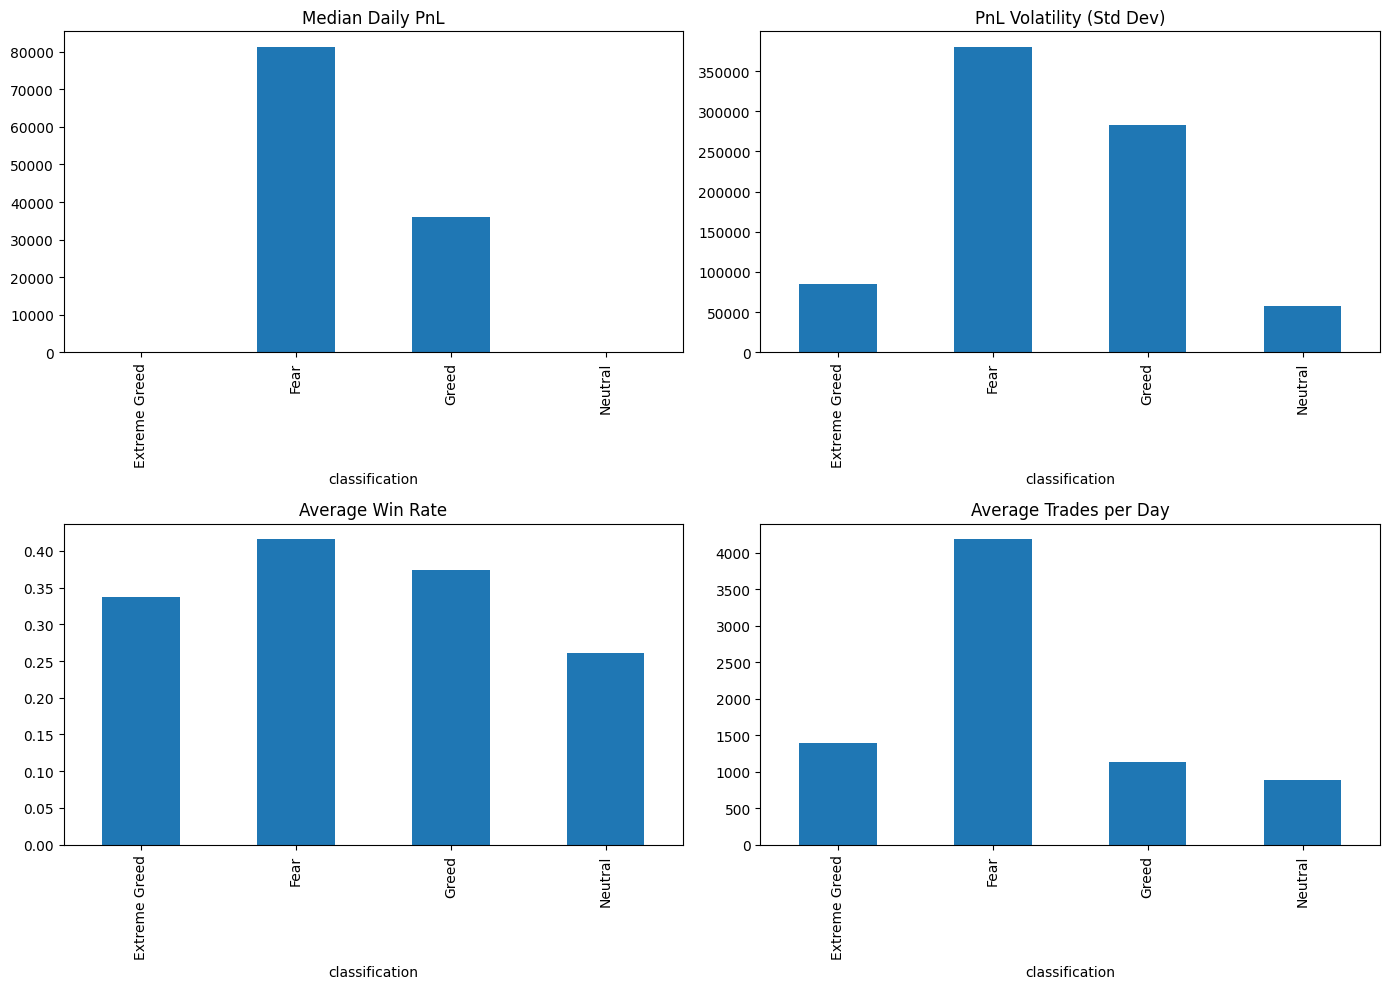

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

analysis_df.groupby('classification')['daily_pnl'].median().plot(
    kind='bar', ax=axes[0,0], title='Median Daily PnL'
)

analysis_df.groupby('classification')['daily_pnl'].std().plot(
    kind='bar', ax=axes[0,1], title='PnL Volatility (Std Dev)'
)

analysis_df.groupby('classification')['win_rate'].mean().plot(
    kind='bar', ax=axes[1,0], title='Average Win Rate'
)
analysis_df.groupby('classification')['trades_per_day'].mean().plot(
    kind='bar', ax=axes[1,1], title='Average Trades per Day'
)
plt.tight_layout()
plt.show()

## Insights on Performance Metrics by Market Sentiment
Market sentiment materially influences both trader behavior and performance. Fear regimes exhibit the highest median daily profitability, highest win rates, and significantly elevated trading activity. However, this profitability comes with the highest volatility, indicating increased risk exposure. Greed regimes show moderate profitability but substantial downside tail risk. Extreme Greed and Neutral regimes exhibit low median profitability and reduced trading intensity, suggesting limited opportunity or overextended market conditions.

The results indicate that trader performance is not uniformly better during optimistic market phases; instead, volatile fear-driven environments appear to generate stronger profit opportunities, albeit with elevated risk.

Strategic advice:

During Fear regimes, allocate more capital but reduce leverage to manage increased volatility.

If Greed shows large downside tail:

During Greed regimes, tighten risk controls and reduce position size to mitigate catastrophic losses.

# Q2 Do traders change behavior based on sentiment (trade frequency, position sizes)?

In [23]:
behaviour_change=daily_metrics.merge(
    sentiment[['timestamp','classification']],
    on='timestamp',
    how='inner')
behavior_summary = (
    behaviour_change
    .groupby('classification')
    .agg(
        avg_trades=('trades_per_day','mean'),
        median_trades=('trades_per_day','median'),
        avg_size=('avg_trade_size','mean'),
    )
    .reset_index()
)

behavior_summary

,classification,avg_trades,median_trades,avg_size
0,Extreme Greed,1392.40000,730.0,4344.447836
1,Fear,4183.46875,2763.5,5926.522723
2,Greed,1134.03125,275.0,5839.310974
3,Neutral,892.62500,164.5,3793.444161


<Axes: title={'center': 'Average Trades per Day by Sentiment'}, xlabel='classification'>

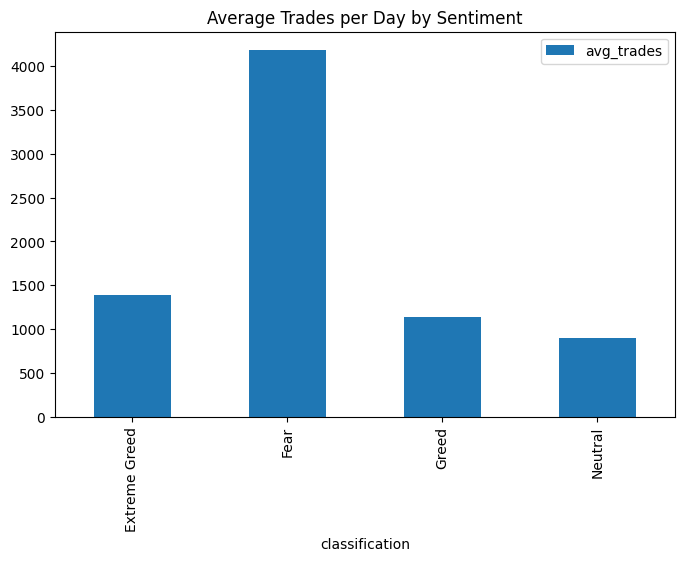

In [26]:
behavior_summary.plot(
    x='classification',
    y='avg_trades',
    kind='bar',
    title='Average Trades per Day by Sentiment',
    figsize=(8,5)
)

<Axes: title={'center': 'Average Trade Size by Sentiment'}, xlabel='classification'>

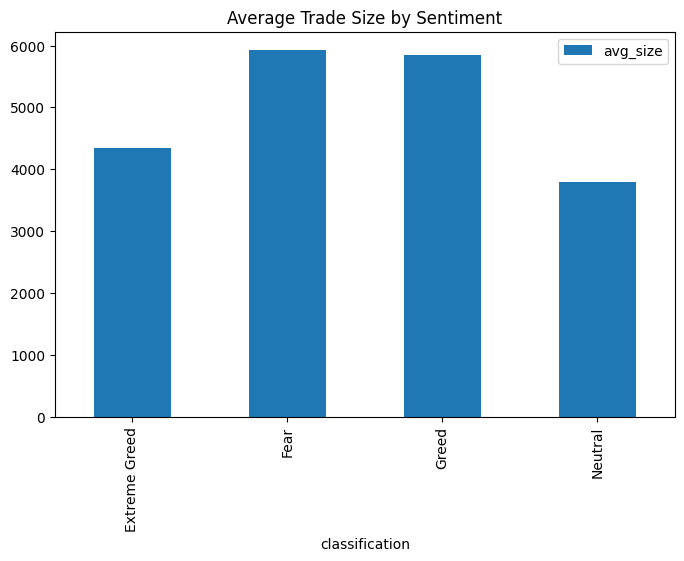

In [25]:
behavior_summary.plot(
    x='classification',
    y='avg_size',
    kind='bar',
    title='Average Trade Size by Sentiment',
    figsize=(8,5)
)

Trader behavior is clearly sentiment-dependent. Fear regimes are associated with significantly higher trading intensity and moderately larger position sizes, indicating elevated engagement and risk-taking during volatile conditions. Neutral regimes show the lowest activity and capital deployment.

## Segmenting traders based on frequency

In [31]:
activity = (
    daily_metrics
    .groupby('Account')['trades_per_day']
    .mean()
    .reset_index()
)
threshold = activity['trades_per_day'].median()

activity['activity_segment'] = np.where(
    activity['trades_per_day'] >= threshold,
    'High Activity',
    'Low Activity'
)
analysis_segmented = analysis_df.merge(
    activity[['Account', 'activity_segment']],
    on='Account',
    how='left'
)
analysis_segmented.groupby(
    ['classification','activity_segment']
)['daily_pnl'].median().reset_index()

,classification,activity_segment,daily_pnl
0,Extreme Greed,High Activity,2606.894756
1,Extreme Greed,Low Activity,-2782.008070
2,Fear,High Activity,131588.010039
3,Fear,Low Activity,55196.899457
4,Greed,High Activity,39978.377910
5,Greed,Low Activity,16102.568590
6,Neutral,High Activity,-4562.497302
7,Neutral,Low Activity,107.377399


Segmentation Analysis: High vs Low Activity Traders

Traders were segmented based on their overall average trade frequency into High Activity and Low Activity groups.

Results indicate that High Activity traders significantly outperform Low Activity traders during Fear regimes, with median daily PnL more than twice as large. A similar, though smaller, advantage is observed during Greed periods.

However, during Neutral regimes, High Activity traders underperform, suggesting that elevated trading intensity is beneficial primarily in volatile environments but detrimental in stable conditions.

This highlights that trading frequency amplifies regime-dependent outcomes.

## Segmenting traders based on constitency

In [34]:
volatility = (
    daily_metrics
    .groupby('Account')['daily_pnl']
    .std()
    .reset_index()
)

threshold = volatility['daily_pnl'].median()

volatility['volatility_segment'] = np.where(
    volatility['daily_pnl'] >= threshold,
    'High Volatility',
    'Low Volatility'
)
analysis_segmented = analysis_segmented.merge(
    volatility[['Account','volatility_segment']],
    on='Account',
    how='left'
)
analysis_segmented.groupby(
    ['classification','volatility_segment']
)['daily_pnl'].median().reset_index()

,classification,volatility_segment,daily_pnl
0,Extreme Greed,High Volatility,1303.447378
1,Extreme Greed,Low Volatility,-5564.016140
2,Fear,High Volatility,210136.081870
3,Fear,Low Volatility,22096.158667
4,Greed,High Volatility,51976.654433
5,Greed,Low Volatility,20766.479658
6,Neutral,High Volatility,31293.172160
7,Neutral,Low Volatility,-4563.078663


Segmentation Analysis: High vs Low Volatility Traders

Traders were segmented based on the standard deviation of their daily PnL into High Volatility and Low Volatility groups.

Results show that High Volatility traders significantly outperform Low Volatility traders during Fear regimes, with median daily PnL nearly ten times larger. A similar, though smaller, advantage is observed during Greed periods.

This indicates that regime-driven opportunities disproportionately benefit traders with higher risk tolerance, while conservative traders experience muted regime sensitivity.